In [ ]:
import torch
import torchvision
import numpy as np
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from PIL import Image
from tqdm import tqdm
from pathlib import Path
from matplotlib import cm
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

from IPython.display import clear_output

import warnings

In [2]:
import kagglehub

path = kagglehub.dataset_download("bloodlaac/products-dataset")

print("Path to dataset files:", path)

d:\Projects\scientific_research\neuronet\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Юля\.cache\kagglehub\datasets\bloodlaac\products-dataset\versions\1


In [3]:
warnings.filterwarnings("ignore")

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
food_dir = f"{path}\products_dataset"

FOOD = [
    'FreshApple', 'FreshBanana', 'FreshMango', 'FreshOrange', 'FreshStrawberry',
    'RottenApple', 'RottenBanana', 'RottenMango', 'RottenOrange', 'RottenStrawberry',
    'FreshBellpepper', 'FreshCarrot', 'FreshCucumber', 'FreshPotato', 'FreshTomato',
    'RottenBellpepper', 'RottenCarrot', 'RottenCucumber', 'RottenPotato', 'RottenTomato'
]

In [6]:
path = Path(food_dir)

In [7]:
class LabeledDataset():
    def __init__(self, food_dir: Path, food_classes: list[str], transform=None):
        self.food_dir = food_dir
        self.food_classes = food_classes
        self.transform = transform
        self.images_paths = []
        self.labels = []

        for cls_name in food_classes:
            class_path = Path(food_dir)
            class_path /= cls_name

            for image_name in class_path.iterdir():
                image_path = class_path / image_name
                self.images_paths.append(image_path)
                self.labels.append(food_classes.index(cls_name))
        
    def __len__(self):
        return len(self.images_paths)
    
    def __getitem__(self, index):
        image = Image.open(self.images_paths[index]).convert("RGB")
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label

In [114]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # TODO: добавить transforms.Normalize
])

In [9]:
food_dataset = LabeledDataset(food_dir, FOOD, transform=data_transforms)

In [10]:
trainset_len = int(0.8 * len(food_dataset))
testset_len = len(food_dataset) - trainset_len

In [11]:
train_dataset, test_dataset = torch.utils.data.random_split(food_dataset, [trainset_len, testset_len])

In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [13]:
def show_image(*, sample: torch.Tensor, channel: int | None = None):
    channels = {
        0: cm.Reds,
        1: cm.Greens,
        2: cm.Blues,
    }
    
    sample = torch.transpose(sample, 0, 2)

    if channel:
        plt.imshow(sample[:, :, channel], cmap=channels[channel])
    else:
        plt.imshow(sample)

In [18]:
img, _ = food_dataset[0]
img = transforms.ToPILImage()(img)
img.show()

In [19]:
sample = next(iter(train_dataloader))[0][0]

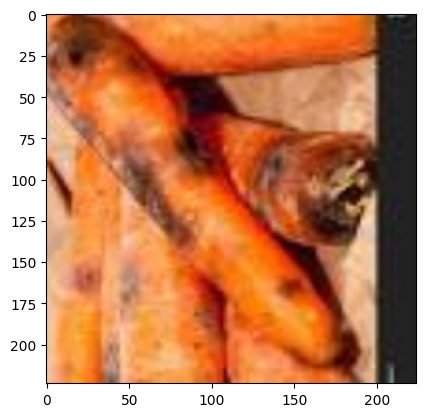

In [20]:
show_image(sample=sample, channel=0)

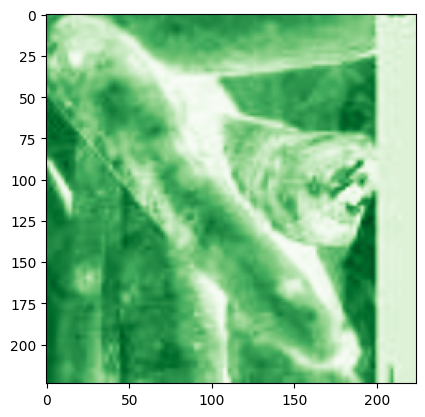

In [21]:
show_image(sample=sample, channel=1)

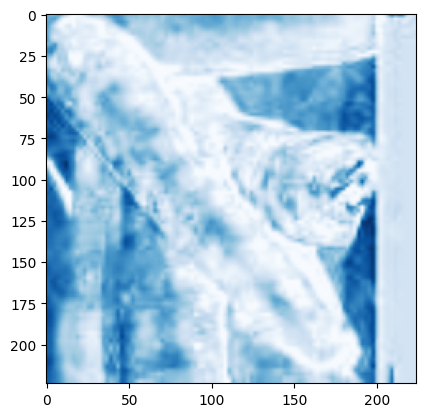

In [22]:
show_image(sample=sample, channel=2)

In [23]:
images, labels = next(iter(train_dataloader))
images_grid = torchvision.utils.make_grid(images)

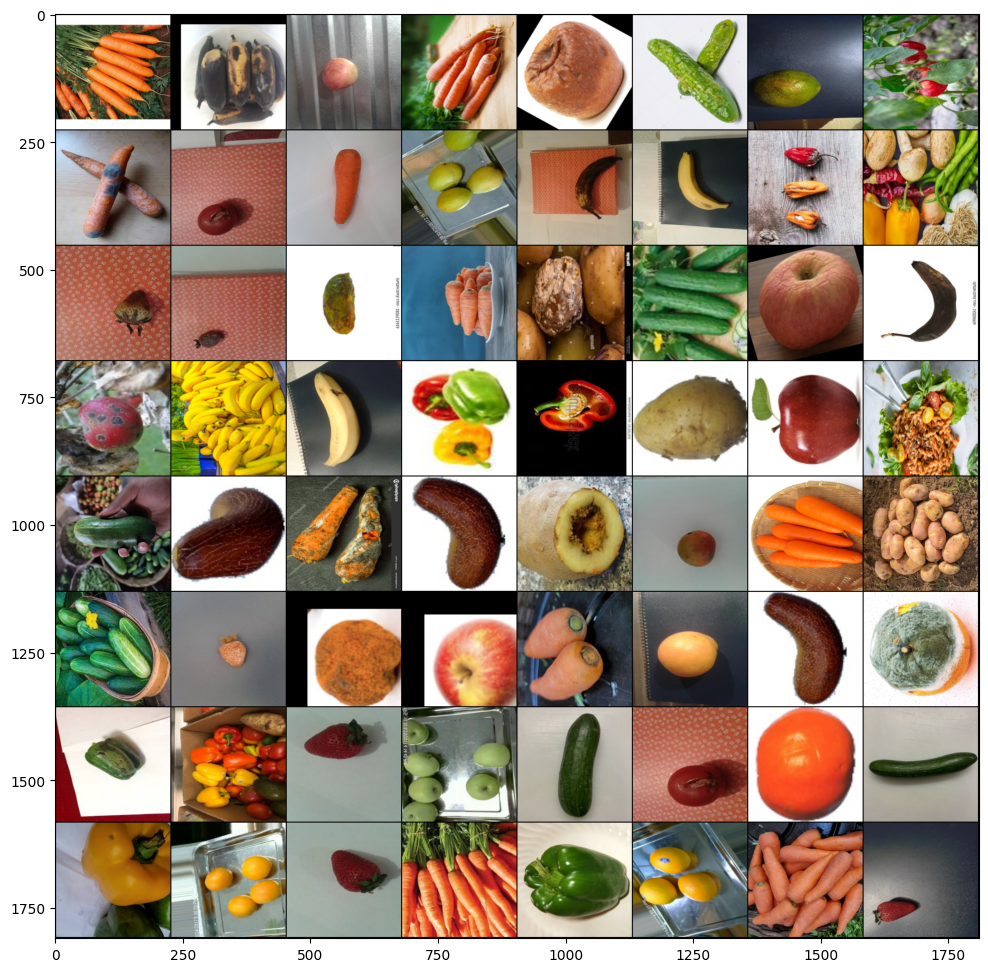

In [24]:
plt.figure(figsize=(12, 12))
show_image(sample=images_grid)

In [246]:
train_samples = 256
val_samples = 64

train_images_list = []
train_labels_list = []
val_images_list = []
val_labels_list = []

for images, labels in test_dataloader:
    val_images_list.append(images)
    val_labels_list.append(labels)

    if sum(len(imgs) for imgs in images) >= val_samples:
        break

all_val_images = torch.cat(val_images_list, dim=0)
all_val_labels = torch.cat(val_labels_list, dim=0)

for images, labels in train_dataloader:
    train_images_list.append(images)
    train_labels_list.append(labels)

    if sum(len(imgs) for imgs in images) >= train_samples:
        break

all_train_images = torch.cat(train_images_list, dim=0)
all_train_labels = torch.cat(train_labels_list, dim=0)

In [247]:
small_transforms = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

In [248]:
all_train_images = small_transforms(all_train_images)
all_val_images = small_transforms(all_val_images)

In [249]:
small_train_dataset = TensorDataset(all_train_images, all_train_labels)
small_val_dataset = TensorDataset(all_val_images, all_val_labels)

In [250]:
small_train_dataloader = DataLoader(small_train_dataset, batch_size=16, shuffle=True)
small_val_dataloader = DataLoader(small_val_dataset, batch_size=8, shuffle=True)

In [251]:
class BaseLine(nn.Module):
    def __init__(self):
        super(BaseLine, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same')
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same')
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding='same')
        self.fc1 = nn.Linear(in_features=256*28*28, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=20)
        self.pooling = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        pred = F.relu(self.conv1(x))
        pred = F.relu(self.conv2(pred))
        pred = self.pooling(pred)
        pred = F.relu(self.conv3(pred))
        pred = F.relu(self.conv4(pred))
        pred = self.pooling(pred)
        pred = F.relu(self.conv5(pred))
        pred = F.relu(self.conv6(pred))
        pred = self.pooling(pred)
        pred = torch.flatten(pred, start_dim=1)
        pred = F.relu(self.fc1(pred))
        pred = self.fc2(pred)
    
        return pred

In [252]:
baseline_model = BaseLine().to(device)

In [253]:
def plot_history(train_history, val_history):
    plt.figure(figsize=(7, 5))
    plt.plot(np.arange(10), train_history, label='Train')
    plt.plot(np.arange(10), val_history, label='Validation')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.grid()
    plt.legend(loc='lower right')
    plt.title('Training')
    plt.show()

In [273]:
def train(
        model: nn.Module,
        criterion, 
        optimizer: torch.optim,
        train_data,
        val_data,
        epochs: int
    ):

    train_loss_log = []
    train_acc_log = []
    val_loss_log = []
    val_acc_log = []

    

    for epoch in (range(epochs)):
        train_epoch_loss = []
        train_epoch_true = []

        model.train()
        
        for i, (images, labels) in enumerate(train_data):
            
        #     for i, (images, labels) in enumerate(tqdm(
        #     train_data,
        #     desc=f'Train. Epoch: [{epoch + 1}/{epochs}]',
        #     leave=False
        # )):

            images, labels = images.to(device), labels.to(device)

            y_pred = model(images)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_epoch_loss.append(loss.cpu().item())
            
            pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
            train_epoch_true.append((pred_classes == labels.cpu()).sum())
            train_loss_log.append(loss.cpu().data / labels.cpu().size(0))
            accuracy = (pred_classes == labels.cpu()).sum() / labels.cpu().size(0)
            train_acc_log.append(accuracy)

            if (i + 1) % 16 == 0:
                print(
                    f'Epoch: [{epoch + 1}/{epochs}], \
                    step: [{train_data.batch_size * (i + 1)}/{len(train_data.dataset)}], \
                    loss: {loss.item():.4f}, \
                    accuracy: {accuracy:.2f}'
                )

        val_epoch_loss = []
        val_epoch_true = []

        model.eval()

        with torch.no_grad():
            for i, (images, labels) in enumerate(tqdm(
                val_data,
                desc=f'Validation. Epoch: [{epoch + 1}/{epochs}]',
                leave=False
            )):
                images, labels = images.to(device), labels.to(device)
                y_pred = model(images)
                loss = criterion(y_pred, labels)
                val_epoch_loss.append(loss.cpu().data / labels.cpu().size(0))
                pred_classes = torch.argmax(y_pred, dim=-1)
                val_epoch_true.append(sum((pred_classes == labels).cpu()))

            val_loss_log.append(sum(val_epoch_loss) / len(val_epoch_loss))
            val_acc_log.append(sum(val_epoch_true) / len(val_epoch_true) / val_data.batch_size)
            
            if (i + 1) % 8 == 0:
                print(
                    f'Epoch [{epoch + 1}/{epochs}], \
                    step: [{val_data.batch_size * (i + 1)}/{len(val_data.dataset)}], \
                    loss: {loss.item():.4f}, \
                    accuracy: {sum(val_epoch_true) / len(val_epoch_true):.2f}'
                )

        print(f'Train loss: {sum(train_epoch_loss) / len(train_epoch_loss)}')
        print(f'Train accuracy: {sum(train_epoch_true) / len(train_epoch_true) / train_data.batch_size}')
        print(f'Validation loss: {sum(val_epoch_loss) / len(val_epoch_loss)}')
        print(f'Validation accuracy: {sum(val_epoch_true) / len(val_epoch_true) / val_data.batch_size}')

    # TODO: написать функцию вывода графика каждую эпоху
    plot_history(train_acc_log, val_acc_log)

In [261]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.01)

In [274]:
train(
    baseline_model,
    criterion=criterion,
    optimizer=optimizer,
    train_data=small_train_dataloader,
    val_data=small_val_dataloader,
    epochs=10
)

Epoch: [1/10],                     step: [256/9600],                     loss: 2.9617,                     accuracy: 0.06
Epoch: [1/10],                     step: [512/9600],                     loss: 3.0006,                     accuracy: 0.00
Epoch: [1/10],                     step: [768/9600],                     loss: 3.0288,                     accuracy: 0.06
Epoch: [1/10],                     step: [1024/9600],                     loss: 3.0326,                     accuracy: 0.00
Epoch: [1/10],                     step: [1280/9600],                     loss: 2.9848,                     accuracy: 0.06
Epoch: [1/10],                     step: [1536/9600],                     loss: 3.0024,                     accuracy: 0.06
Epoch: [1/10],                     step: [1792/9600],                     loss: 3.0079,                     accuracy: 0.00
Epoch: [1/10],                     step: [2048/9600],                     loss: 3.0319,                     accuracy: 0.00
Epoch: [1/10],     

Epoch [1/10],                     step: [64/64],                     loss: 3.0041,                     accuracy: 0.38
Train loss: 2.9992083732287087
Train accuracy: 0.048645831644535065
Validation loss: 0.3742330074310303
Validation accuracy: 0.046875
Epoch: [2/10],                     step: [256/9600],                     loss: 2.9778,                     accuracy: 0.12
Epoch: [2/10],                     step: [512/9600],                     loss: 2.9867,                     accuracy: 0.00
Epoch: [2/10],                     step: [768/9600],                     loss: 3.0056,                     accuracy: 0.00
Epoch: [2/10],                     step: [1024/9600],                     loss: 3.0038,                     accuracy: 0.06
Epoch: [2/10],                     step: [1280/9600],                     loss: 3.0000,                     accuracy: 0.06
Epoch: [2/10],                     step: [1536/9600],                     loss: 3.0098,                     accuracy: 0.00
Epoch: [2/10]

Epoch [2/10],                     step: [64/64],                     loss: 2.9999,                     accuracy: 0.50
Train loss: 2.9990228577454885
Train accuracy: 0.04749999940395355
Validation loss: 0.3752366006374359
Validation accuracy: 0.0625
Epoch: [3/10],                     step: [256/9600],                     loss: 2.9870,                     accuracy: 0.00
Epoch: [3/10],                     step: [512/9600],                     loss: 3.0084,                     accuracy: 0.06
Epoch: [3/10],                     step: [768/9600],                     loss: 2.9993,                     accuracy: 0.00
Epoch: [3/10],                     step: [1024/9600],                     loss: 2.9874,                     accuracy: 0.12
Epoch: [3/10],                     step: [1280/9600],                     loss: 2.9807,                     accuracy: 0.06
Epoch: [3/10],                     step: [1536/9600],                     loss: 3.0126,                     accuracy: 0.00
Epoch: [3/10],  

KeyboardInterrupt: 